# Исследование данных сервиса аренды самокатов
Сервис аренды самокатов предоставил для анализа данные о некоторых пользователях из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;


- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно. 
    
**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи:
- `user_id` - уникальный идентификатор пользователя
- `name` - имя пользователя
- `age` - возраст
- `city` - город
- `subscription_type` - тип подписки (free, ultra)

Поездки:
- `user_id` - уникальный идентификатор пользователя
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` - дата совершения поездки

Подписки:
- `subscription_type` - тип подписки
- `minute_price` - стоимость одной минуты поездки по данной подписке
- `start_ride_price` - стоимость начала поездки
- `subscription_fee` - стоимость ежемесячного платежа

**Задача**: Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.


**План работы**

- ознакомление с исходными данными
- предобработка данных
- выявление закономерностей и зависимостей, визуализация
- формулирование и проверка гипотез с целью выявления оптимальной стратегии увеличения количества пользователей с подпиской
- составление итогового вывода

#### Шаг 1. Загрузка данных

In [1]:
# импорт бибилиотек

import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.stats import binom, norm
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# загрузка данных

paths1 = ['/datasets/users_go.csv', '/datasets/rides_go.csv', '/datasets/subscriptions_go.csv']
paths2 = ['users_go.csv', 'rides_go.csv', 'subscriptions_go.csv']
dfs = []

for i in range(len(paths1)):
    if os.path.exists(paths1[i]):
        dfs.append(pd.read_csv(paths1[i]))
    elif os.path.exists(paths2[i]):
        dfs.append(pd.read_csv(paths2[i]))
    else:
        print('File is missing')
        
users = dfs[0]
rides = dfs[1]
subscriptions = dfs[2]

##### users

In [3]:
# просмотр первых строк таблицы users

users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
# просмотр общей информации о таблице users

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В таблице содержатся данные о 1565 пользователях приложения. Пропусков данных нет, форматы данных изменять не требуется. Необходимо проверить данные на наличие дубликатов.

##### rides

In [5]:
# просмотр первых строк таблицы rides

rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
# просмотр общей информации о таблице rides

rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В таблице содержатся данные о 18068 поездках. Пропусков данных нет. Необходимо выполнить следующее:
- проверить данные на наличие дубликатов
- привести столбец `'date'` к типу datetime
- устранить возможные аномалии

##### subscriptions

In [7]:
# просмотр первых строк таблицы subscriptions

subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
# просмотр общей информации о таблице subscriptions

subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Таблица состоит из двух строк, содержащих информацию о двух типах подписки. Предобработка данных не требуется.

#### Шаг 2. Предобработка данных

##### users

In [9]:
# подсчет количества дубликатов

users.duplicated().sum()

31

In [10]:
# удаление дубликатов

users = users.drop_duplicates()

##### rides

In [11]:
# подсчет количества дубликатов

rides.duplicated().sum()

0

In [12]:
# просмотр статистической информации 

rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


Просмотр статистической информации выявил наличие очень коротких поездок (продолжительность 30 секунд), а также большого разбега в данных о расстоянии, пройденном за одну сессию (от 0,8 метра до 7,2 км). Рассчитаем скорость передвижения в каждой сессии (в км/ч) и воспользуемся ею для выявления аномальных поездок.

In [13]:
rides['velocity'] = (rides['distance'] / 1000) / (rides['duration'] / 60)

In [14]:
rides['velocity'].describe()

count    18068.000000
mean        13.785261
std         44.156189
min          0.005133
25%          8.127843
50%         10.251135
75%         12.929800
max        865.320929
Name: velocity, dtype: float64

В таблице содержатся аномальные данные (максимальная скорость 865 км/ч). Построим диаграмму размаха для определения порогов отсечения данных.

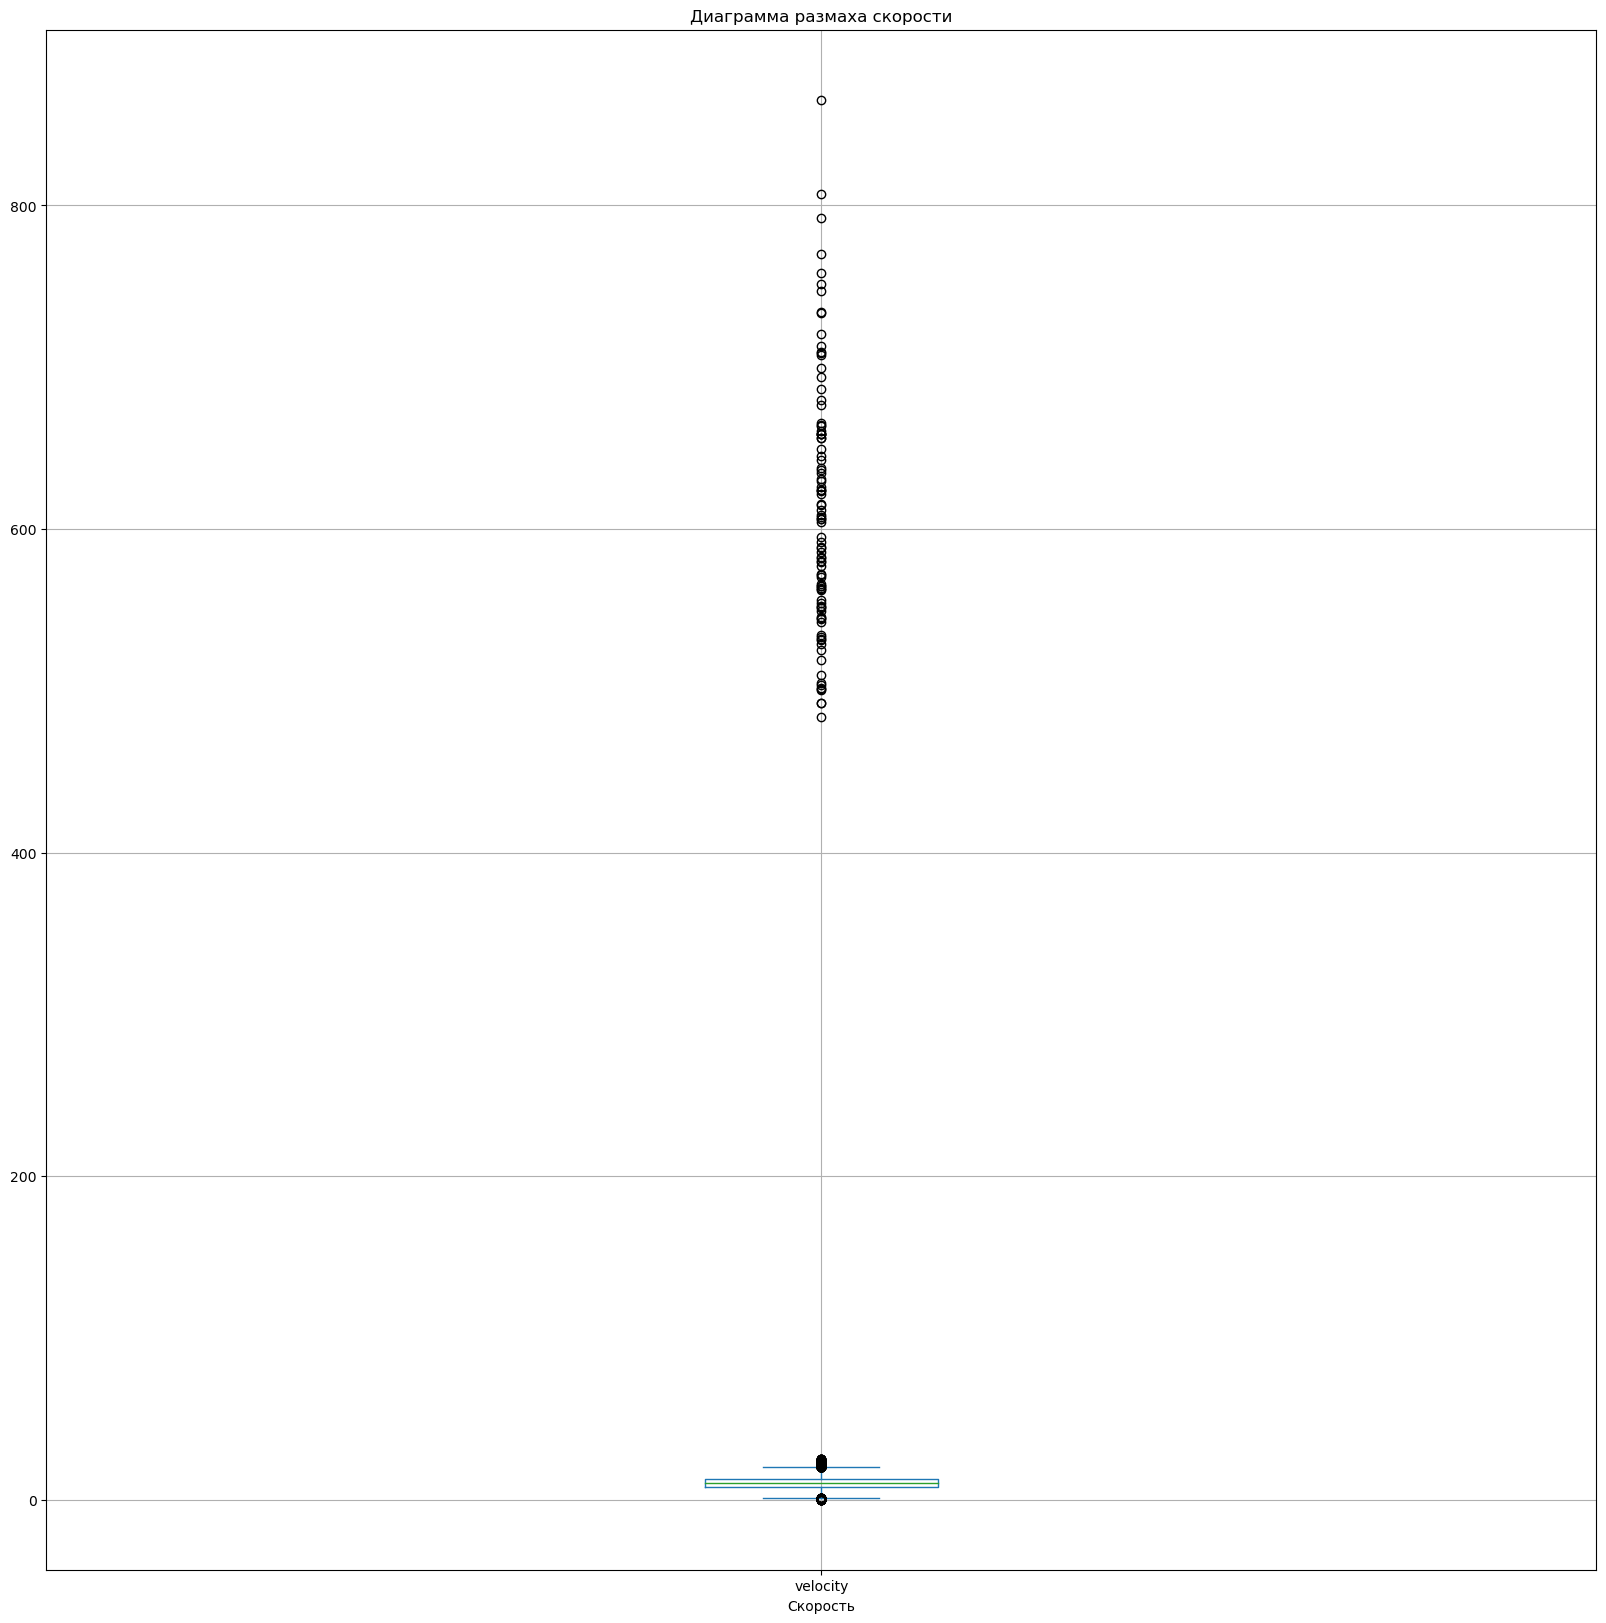

In [15]:
rides['velocity'].plot.box(grid=True, figsize=(20, 20))
plt.xlabel('Скорость')
plt.title('Диаграмма размаха скорости')
plt.show()

Большая часть выбросов значительно превышает значение в 400 км/ч. Чтобы уточнить максимальную границу отсечения данных, посмотрим, какое максимальное значение скорости мы получим, если уберем явно аномальные значения.

In [16]:
rides.query('velocity < 400')['velocity'].max()

25.39027482805915

Без этих выбросов максимальная наблюдаемая скорость передвижения немного превышает 25 км/ч (что, конечно, слегка превышает максимально разрешенную скорость передвижения на самокатах, но аномальным значением само по себе не является). Таким образом, максимальный порог отсечения можно установить в 26 км/ч. Проверим, сколько процентов данных мы потеряем, если уберем строки с аномальными значениями скорости.

In [17]:
print(f'Потери данных составят {round(100 * len(rides.query("velocity > 26")) / len(rides), 2)} %.')
print(f'Будет удалено строк: {len(rides.query("velocity > 26"))}')

Потери данных составят 0.53 %.
Будет удалено строк: 95


In [18]:
rides = rides.query('velocity < 26')

In [19]:
# приведение данных в столбце 'date' к формату datetime

rides.loc[:,'date'] = pd.to_datetime(rides.loc[:,'date'], format='%Y-%m-%d')

In [20]:
# создание столбца с номером месяца для дальнейшего анализа показателей по месяцам

rides.loc[:,'month'] = rides.loc[:,'date'].dt.month

In [21]:
# определяем границы рассматриваемого периода

rides['date'].describe(datetime_is_numeric=True)

count                            17973
mean     2021-06-30 19:41:36.745117696
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

В таблице представлены данные о поездках, совершенных в период с 1 января по 30 декабря 2021 года.

Выполнены следующие шаги:
- удален 31 дубликат в таблице `'users'`
- рассчитана скорость передвижения в каждой сессии на основе данных из таблицы `'rides'`
- из таблицы `'rides'` удалены данные о 95 поездках с аномально высокими значениями скорости (0,53% данных)
- столбец `'date'` в таблице `'rides'` приведен к формату datetime
- в таблицу `'rides'` добавлен столбец `'month'` с номером месяца


#### Шаг 3. Исследовательский анализ данных

Опишием и визуализируем общую информацию о пользователях и поездках:
- частота встречаемости городов
- соотношение пользователей с подпиской и без подписки
- возраст пользователей
- расстояние, которое пользователь преодолел за одну поездку
- продолжительность поездок

##### Частота встречаемости городов

In [22]:
users['city'].value_counts(ascending=True)

Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64

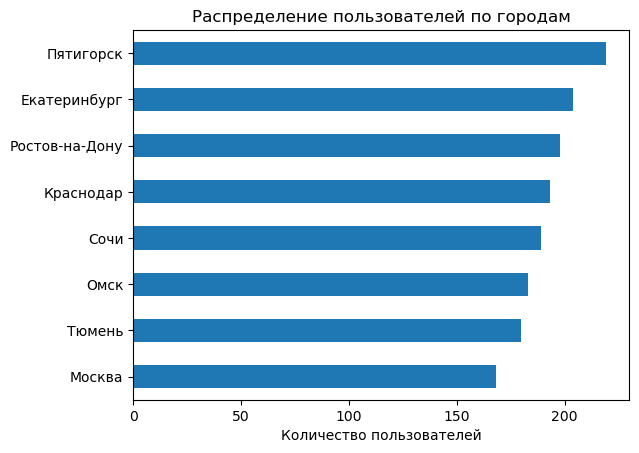

In [23]:
users['city'].value_counts(ascending=True).plot.barh()

plt.title('Распределение пользователей по городам')
plt.xlabel('Количество пользователей')
plt.show()

Из восьми представленных городов больше всего клиентов проживают в Пятигорске (219), меньше всего - в Москве (168).

##### Соотношение пользователей с подпиской и без подписки

In [24]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

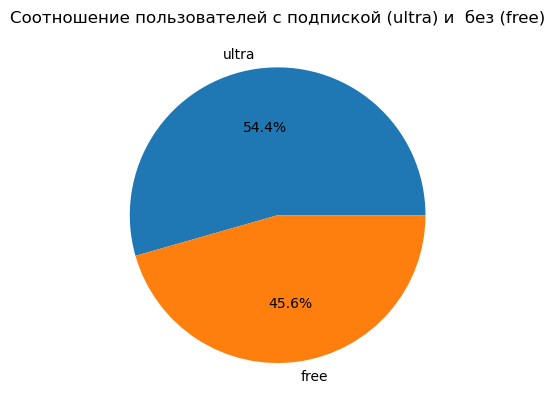

In [25]:
ax = plt.subplot()
ax.pie(users['subscription_type'].value_counts(), labels=users['subscription_type'].unique(), autopct='%1.1f%%')

plt.title('Соотношение пользователей с подпиской (ultra) и  без (free)')
plt.show()

Пользователей без подписки в данных представлено больше, чем пользователей с подпиской (835 и 699 соответственно).

##### Возраст пользователей

In [26]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

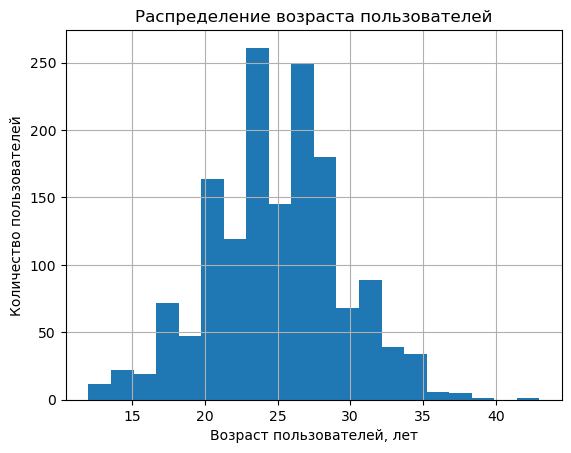

In [27]:
users['age'].plot.hist(bins=20, grid=True)

plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст пользователей, лет')
plt.ylabel('Количество пользователей')

plt.show()

Большей части пользователей от 20 до 29 лет (медианный возраст 25 лет). Пользователей старше 35 лет представлено очень мало, максимальный возраст - 43 года. Минимальный возраст в подборке - 12 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

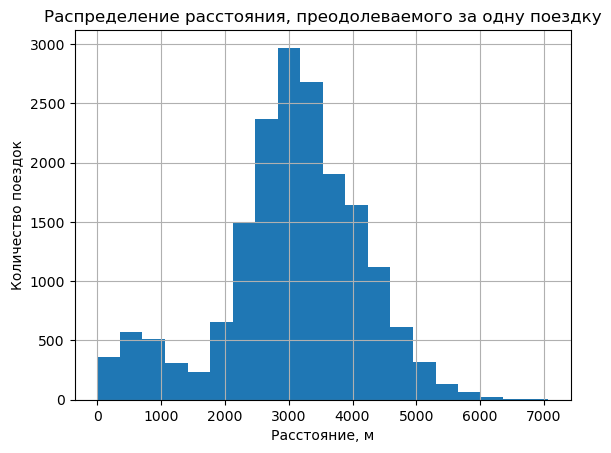

In [28]:
rides['distance'].plot.hist(bins=20, grid=True)

plt.title('Распределение расстояния, преодолеваемого за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')

plt.show()

В подавляющем большинстве случаев расстояние, преодолеваемое за одну поездку, составляет 2,8-3,5 км.

##### Продолжительность поездок

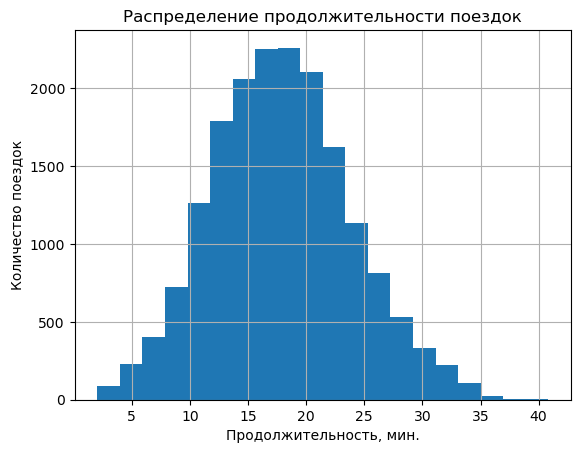

In [29]:
rides['duration'].plot.hist(bins=20, grid=True)

plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность, мин.')
plt.ylabel('Количество поездок')

plt.show()

Продолжительность большинства поездок составляет 16-20 минут. Поездки дольше 35 минут встречаются редко.

##### Количество поездок по месяцам
Рассмотрим дополнительно, как меняется количество поездок по месяцам.

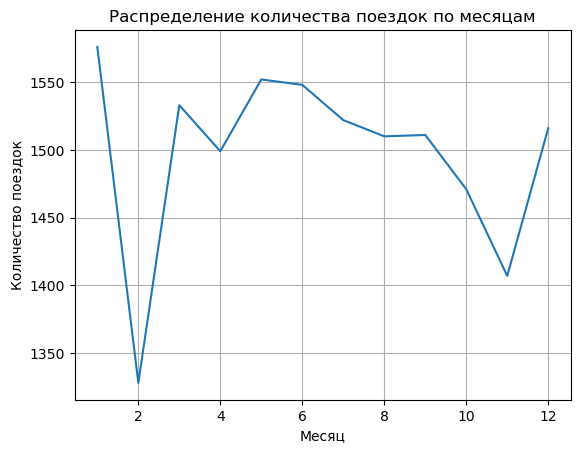

In [30]:
rides.pivot_table(index='month', values='duration', aggfunc='count').plot(legend=False, grid=True)

plt.title('Распределение количества поездок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество поездок')
plt.show()

Мы видим, что в целом в течение 2021 года количество поездок в месяц находилось в пределах 1450-1550 за исключением февраля и ноября, когда количество поездок сильно снижалось. Пик приходился на январь.

#### Шаг 4. Объединение данных

In [31]:
# объединение данных из таблиц users и rides

data = users.merge(rides, on='user_id', how='left')

In [32]:
# добавление в общую таблицу данных из таблицы subscriptions

data = data.merge(subscriptions, on='subscription_type', how='left')

In [33]:
len(data) == len(rides)

True

In [34]:
# создание отдельных датафреймов для пользователей с подпиской и без

data_ultra = data.query('subscription_type == "ultra"')
data_free = data.query('subscription_type == "free"')

In [35]:
print(f'Пользователей с подпиской: {len(data_ultra["user_id"].unique())}')
print(f'Поездок у пользователей с подпиской: {len(data_ultra)}')
print(f'Поездок на каждого пользователя с подпиской: {round(len(data_ultra) / len(data_ultra["user_id"].unique()), 2)}')
print(f'Доля поездок по подписке от общего количества поездок: {round(100*len(data_ultra) / len(data))}%')
print()
print(f'Пользователей без подписки: {len(data_free["user_id"].unique())}')
print(f'Поездок у пользователей без подписки: {len(data_free)}')
print(f'Поездок на каждого пользователя без подписки: {round(len(data_free) / len(data_free["user_id"].unique()), 2)}')
print(f'Доля поездок без подписки от общего количества поездок: {round(100*len(data_free) / len(data))}%')

Пользователей с подпиской: 699
Поездок у пользователей с подпиской: 6500
Поездок на каждого пользователя с подпиской: 9.3
Доля поездок по подписке от общего количества поездок: 36%

Пользователей без подписки: 835
Поездок у пользователей без подписки: 11473
Поездок на каждого пользователя без подписки: 13.74
Доля поездок без подписки от общего количества поездок: 64%


Как мы видим, большинство пользователей не подключают подписки. На долю пользователей с подпиской приходится всего 36% поездок от общего количества.

Рассмотрим также данные о медианной продолжительности и пройденном расстоянии у разных категорий пользователей.

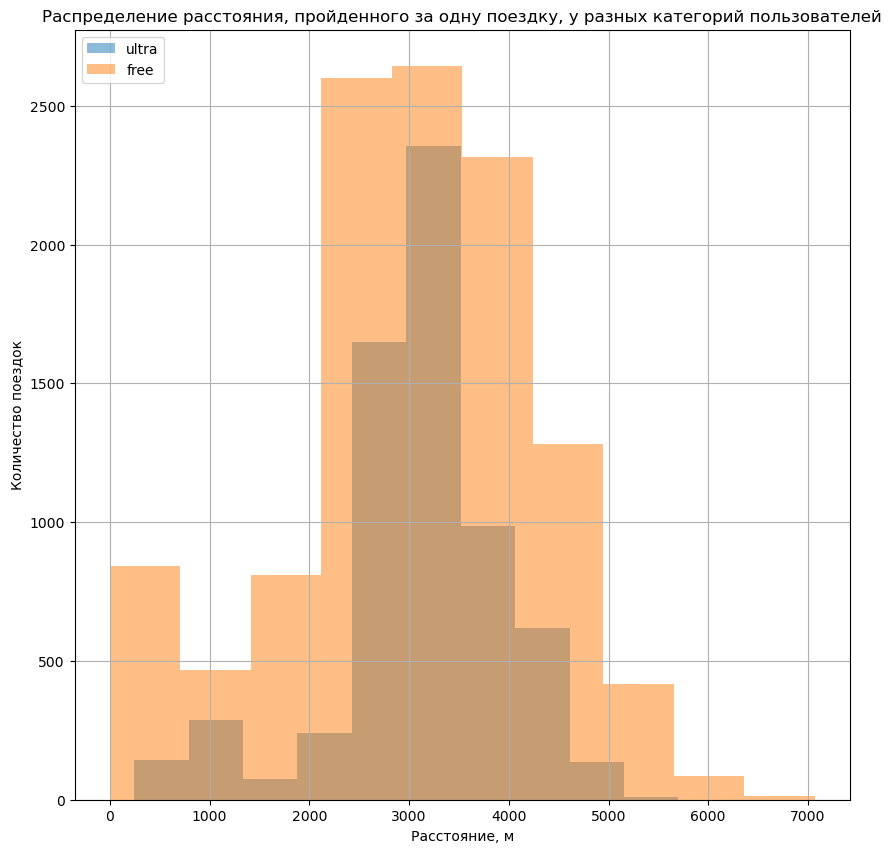

In [36]:
plt.figure(figsize=(10, 10))
plt.grid(True)

plt.hist(data_ultra['distance'], alpha = 0.5, label='ultra')
plt.hist(data_free['distance'], alpha = 0.5, label='free')
plt.legend(loc='upper left')

plt.title('Распределение расстояния, пройденного за одну поездку, у разных категорий пользователей')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

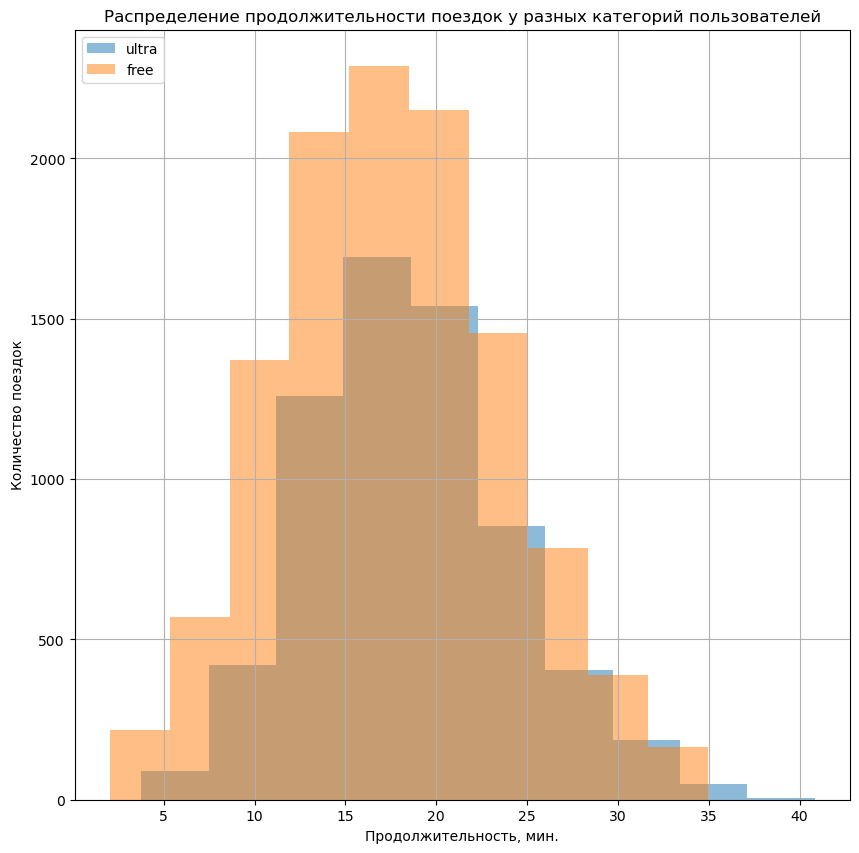

In [37]:
plt.figure(figsize=(10, 10))
plt.grid(True)

plt.hist(data_ultra['duration'], alpha = 0.5, label='ultra')
plt.hist(data_free['duration'], alpha = 0.5, label='free')
plt.legend(loc='upper left')

plt.title('Распределение продолжительности поездок у разных категорий пользователей')
plt.xlabel('Продолжительность, мин.')
plt.ylabel('Количество поездок')
plt.show()

У пользователей с подпиской мы наблюдаем пик количества пользователей, передвигающихся на расстояние 3-3,5 км за поездку, которая занимает в большинстве случаев от 15 до 22 минут. У пользователей без подписки более широкий диапазон протяженности поездок (2-5 км у большинства), продолжительность поездок в большинстве случаев составляет от 12 до 25 минут.

Можем предположить, что пользователи с подпиской более регулярно используют самокаты для передвижения по примерно одним и тем же маршрутам, а у пользователей без подписки ярко выраженной модели использования самокатов нет.

#### Шаг 5. Подсчёт выручки

Для подсчета выручки создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также добавим в датафрейм столбцы со значениями стоимости одной минуты поездки по подписке, стоимости начала поездки, стоимости ежемесячного платежа для каждого пользователя, а также столбец с типом подписки, рассчитаем на их основе выручку, которую приносит каждый пользователь каждый месяц.

In [38]:
# округляем продолжительность поездки в исходном датафрейме до целого числа
data['duration'] = np.ceil(data['duration']) 


# создаем сводную таблицу
data_agg = data.groupby(['user_id', 'month']).agg({'distance':'sum', 'duration':['sum', 'count'],
                                                   'subscription_type':'first', 'minute_price':'mean',
                                                  'start_ride_price':'mean', 'subscription_fee':'mean'})

# переименовываем для удобства колонки сводной таблицы
data_agg.columns = ['distance_sum', 'duration_sum', 'rides_qty', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']

# рассчитываем и добавляем выручку
data_agg['revenue'] = (data_agg['start_ride_price'] * data_agg['rides_qty']) + data_agg['minute_price'] * data_agg['duration_sum'] + data_agg['subscription_fee']

In [39]:
# создание двух отдельных сводных таблиц для пользователей с подпиской и пользователей без подписки

df_ultra_agg = data_agg.query('subscription_type == "ultra"')
df_free_agg = data_agg.query('subscription_type == "free"')

Сравним помесячную выручку, получаемую от пользователей разных категорий.

In [40]:
df_free_agg['revenue'].describe()

count    6767.000000
mean      329.332644
std       183.268419
min        74.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: revenue, dtype: float64

In [41]:
df_ultra_agg['revenue'].describe()

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: revenue, dtype: float64

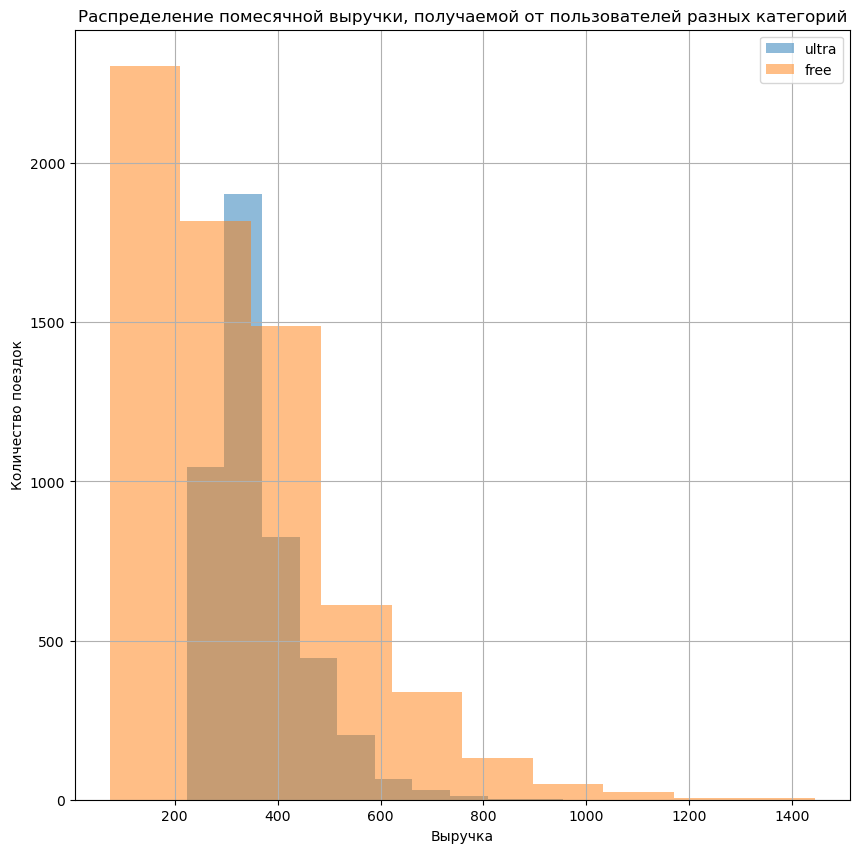

In [42]:
plt.figure(figsize=(10, 10))
plt.grid(True)

plt.hist(df_ultra_agg['revenue'], alpha = 0.5, label='ultra')
plt.hist(df_free_agg['revenue'], alpha = 0.5, label='free')

plt.legend(loc='upper right')

plt.title('Распределение помесячной выручки, получаемой от пользователей разных категорий')
plt.xlabel('Выручка')
plt.ylabel('Количество поездок')
plt.show()

Гистограмма распределения помесячной выручки показывает, что большинство пользователей с подпиской приносят в месяц больше выручки, чем большинство пользователей без подписки (медианное значение 337,00 и 274,00 руб. соответственно). При этом очевидна разница в количестве поездок: пользователей без подписки больше, и они совершают больше поездок в течение месяца.

#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки?

С помощью t-теста сравним среднюю продолжительность поездок у пользователей с разными типами подписок. Нулевая гипотеза: средняя продолжительность поездок у пользователей с разными типами подписок одинаковая. Альтернативная гипотеза: средняя продолжительность поездок у пользователей с подпиской больше, чем у пользователей без подписки.

In [43]:
alpha = 0.05

results = stats.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater', equal_var=False)

print('Нулевая гипотеза: пользователи с подпиской в среднем столько же времени на поездки, что и пользователи без подписки.')
print('Альтернативная гипотеза: пользователи с подпиской в среднем тратят больше времени на поездки.')
print()

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.') 
    
print()
print(f'Средняя продолжительность поездок пользователей с подпиской: {round(data_ultra["duration"].mean(), 1)} минут.')
print(f'Средняя продолжительность поездок пользователей без подписки: {round(data_free["duration"].mean(), 1)} минут.')    

Нулевая гипотеза: пользователи с подпиской в среднем столько же времени на поездки, что и пользователи без подписки.
Альтернативная гипотеза: пользователи с подпиской в среднем тратят больше времени на поездки.

Отвергаем нулевую гипотезу.

Средняя продолжительность поездок пользователей с подпиской: 18.5 минут.
Средняя продолжительность поездок пользователей без подписки: 17.5 минут.


Результат теста показывает, что вероятность совпадения средних значений длительности поездок у пользователей с разными типами подписок очень мала, а значит, мы отвергаем нулевую гипотезу в пользу альтернативной: пользователи с подпиской в среднем тратят больше времени на поездки.

##### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

С помощью t-теста сравним среднюю протяженность поездок у пользователей с подпиской со значением 3130 метров. Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Альтернативная гипотеза: средняя протяженность поездки у пользователей с подпиской больше 3130 метров.

In [44]:
optimal_distance = 3130

alpha = 0.05

results = stats.ttest_1samp(data_ultra['distance'], optimal_distance, alternative='greater')

print('Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.')
print('Альтернативная гипотеза: пользователи с подпиской в среднем проезжают больше 3130 метров.')
print()

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не отвергаем нулевую гипотезу.') 

print()
print(f'Средняя протяженность поездки у пользователей с подпиской составляет {round(data_ultra["distance"].mean())} метров.')

Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
Альтернативная гипотеза: пользователи с подпиской в среднем проезжают больше 3130 метров.

Не отвергаем нулевую гипотезу.

Средняя протяженность поездки у пользователей с подпиской составляет 3115 метров.


Результат теста показывает, что значение p-value слишком велико, чтобы бы могли опровергнуть нулевую гипотезу в пользу альтернативной, а это значит, что в среднем пользователи с подпиской проезжают меньше 3130 метров за одну поездку.

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

С помощью t-теста сравним среднюю помесячную выручку от пользователей с разными типами подписок. Нулевая гипотеза: средняя помесячная выручка от пользователей с разными типами подписок одинаковая. Альтернативная гипотеза: средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

In [45]:
alpha = 0.05

results = stats.ttest_ind(df_ultra_agg['revenue'], df_free_agg['revenue'], alternative='greater', equal_var=False)

print('Нулевая гипотеза: средняя помесячная выручка от пользователей с подпиской такая же, как и  от пользователей без подписки.')
print('Альтернативная гипотеза: средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.')
print()

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не отвергаем нулевую гипотезу.')
    
print()
print(f'Средняя выручка от пользователей с подпиской: {round(df_ultra_agg["revenue"].mean(), 1)} рублей в месяц.')
print(f'Средняя выручка от пользователей без подписки: {round(df_free_agg["revenue"].mean(), 1)} рублей в месяц.') 

Нулевая гипотеза: средняя помесячная выручка от пользователей с подпиской такая же, как и  от пользователей без подписки.
Альтернативная гипотеза: средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

Отвергаем нулевую гипотезу.

Средняя выручка от пользователей с подпиской: 362.8 рублей в месяц.
Средняя выручка от пользователей без подписки: 329.3 рублей в месяц.


Результат теста показывает, что вероятность совпадения средних значений помесячной выручки от пользователей с разными типами подписок очень мала, а значит, мы отвергаем нулевую гипотезу в пользу альтернативной: средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

##### Какой тест вам понадобился бы для проверки гипотезы о снижении колчества обращений в техподдержку после обновления?

Так как в этом случае выборки зависимы, мы воспользовались бы методом `scipy.stats.ttest_rel()`. В качестве аргументов в метод передавалось бы количество обращений в техподдержку до внедрения обновления и после него.

Нулевая гипотеза: количество обращений в техподдержку после внедрения обновления не изменилось. Альтернативная гипотеза: количество обращений в техподдержку после внедрения обновления снизилось.

Примерный код для проведения такого теста представлен ниже:

```
    alpha = 0.05

    results = stats.ttest_rel(data_before['support_requests'], data_after['support_requests'], alternative='greater')

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу о равенстве количества обращений в техподдержку до обновления и после него.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу о равенстве количества обращений в техподдержку до обновления и после него.')
```

#### Шаг 7. Распределения

##### Акция с раздачей промокодов

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Поскольку после бесплатного пробного периода подписку продлевают всего 10% пользователей, для получения результата в 100 новых продлений необходимо разослать не меньше 1000 промокодов. Рассчитаем, при каком минимальном значении количества разосланных промокодов вероятность получения менее 100 подписок составит не более 5%, а затем используем это значение для построения графика распределения.

Минимальное количество промокодов для рассылки: 1161


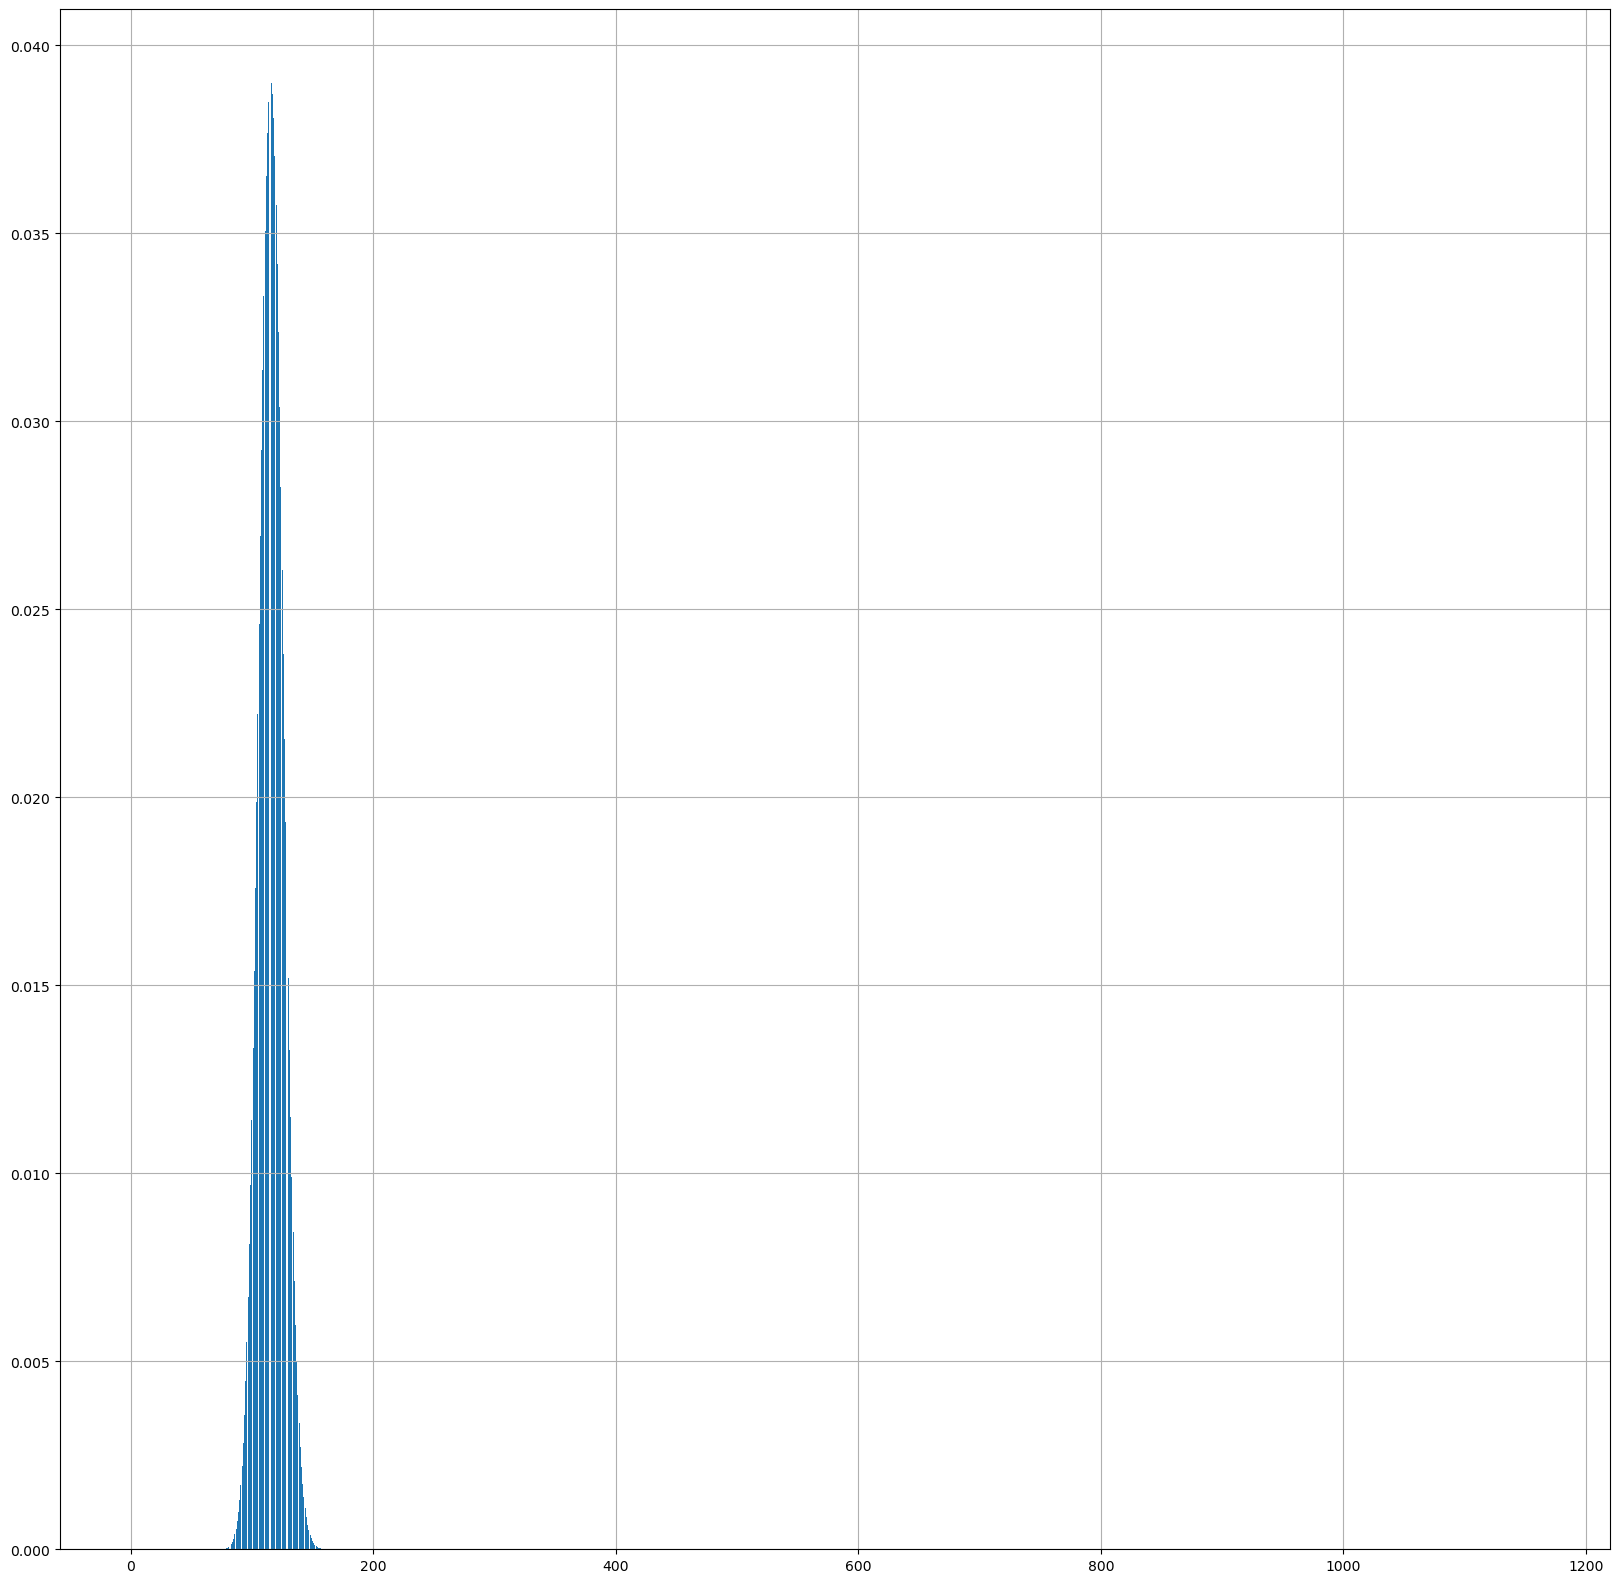

In [46]:
codes = []
p = 0.1

for i in range(1000, 2000):
    if binom.cdf(99, i, p) <= 0.05:
        codes.append(i)
print(f'Минимальное количество промокодов для рассылки: {min(codes)}')

n = min(codes)

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.bar(range(0, n + 1), distr)
plt.show()

Для того, чтобы вероятность не выполнить план в 100 новых подписок была примерно 5% (при условии, что подписку после завершения пробного периода продлевают 10% пользователей), необходимо разослать минимум 1161 промокод. График распределения показывает, что в хвост слева от значения 100 при таком количестве разосланных промокодов попадают не более 5% исходов.

##### Рассылка пуш-уведомлений

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Воспользуемся нормальной аппроксимацией биномиального распределения, построим графики распределения и посчитаем вероятность получения значения меньше 399500.

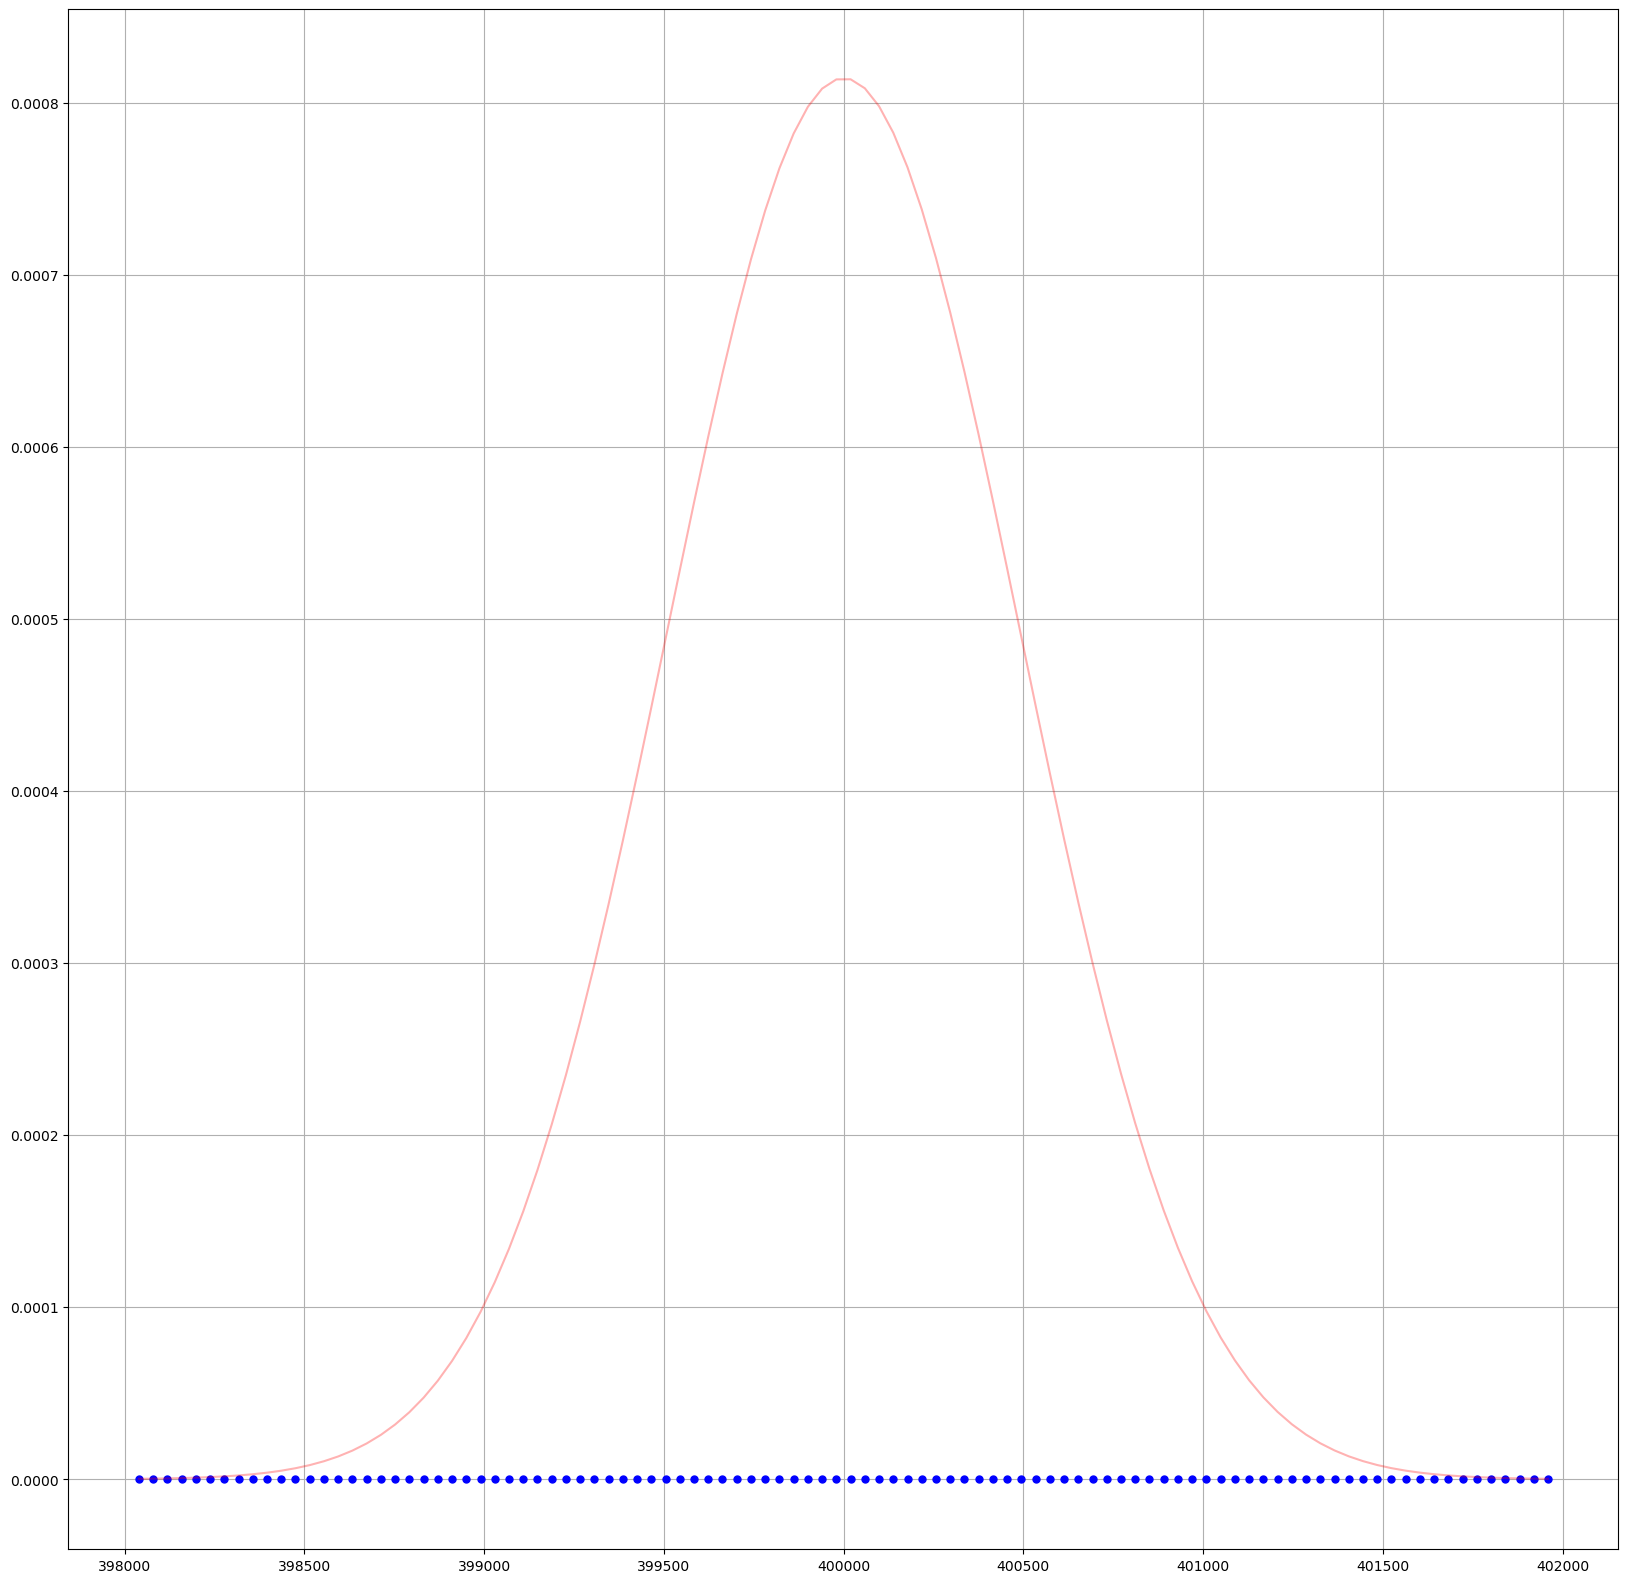

Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей, составляет 15.4%.


In [47]:
# задаем функцию, генерирующую заданное количество равномерно распределенных чисел для визуализции распределения
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# задаем параметры биномиального распределения
n = 1000000
p = 0.4

# задаем границы промежутка, в котором будем строить аппроксимацию
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

# задаем набор значений биномиальной величины на выбранном промежутке
x = linspace(left, right, 100)

# задаем размер графика и отображение сетки
plt.figure(figsize=(20, 20))
plt.grid(True)

# строим график биномиального распределения
ax = plt.subplot()
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=5, label='биномиальное распределение')

# задаем параметры нормального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# строим график нормального распределения
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', alpha=0.3, label='нормальное распределение')

plt.show()

# подсчитываем вероятность того, что уведомление откроют не более 399,5 тысяч пользователей
distr = stats.norm(mu, sigma)
result = distr.cdf(399500)

print(f'Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей, составляет {round(result*100, 1)}%.')

Мы видим, что вероятность того, что уведомление откроют не более 399,5 тысяч пользователей, составляет 15,4%. Это значит, что вероятность того, что его откроют более 399,5 тысяч пользователей, составляет в данном случае 84,6%.

#### Общий вывод

##### Введение
Для анализа были предоставлены данные сервиса аренды самокатов. Исходные данные представляли собой три таблицы: информация о 1565 пользователях приложения, информация о 18068 совершенных поездках и информация о типе подписки. Необходимо было изучить данные и проверить ряд гипотез, которые могут помочь увеличить прибыль.

##### Предобработка данных
Изучение исходных данных выявило наличие аномальных значений и дубликатов в данных.

###### Таблица users
- удален 31 полный дубликат

###### Таблица rides
- добавлен столбец `'velocity'` с указанием скорости передвижения в каждой сессии
- после анализа столбца `'velocity'` удалены 95 строк с аномальными значениями скорости
- столбец `'date'` приведен к типу datetime
- добавлен столбец `'month'` с номером месяца поездки

##### Исследовательский анализ данных

###### Изучение частоты встречаемости городов
Установлено, что из восьми представленных городов больше всего клиентов проживают в Пятигорске (219), меньше всего - в Москве (168).

###### Изучение соотношения пользователей с подпиской и без подписки
Установлено, что пользователей без подписки в данных представлено больше, чем пользователей с подпиской (835 и 699 соответственно).

###### Изучение возраста пользователей
Установлено, что медианный возраст пользователей сервиса составляет 25 лет. Минимальное значение - 12 лет, максимальное - 43 года.

###### Изучение расстояния
Установлено, что медианное расстояние, преодолеваемое за одну поездку, составляет 2,8-3,5 км.

###### Изучение продолжительности поездок
Установлено, что медианная продолжительность большинства поездок составляет 16-20 минут. 

##### Объединение данных
С помощью метода `merge()` данные из трех таблиц были объединены в общую таблицу, которая затем была разделена на две таблицы: данные по пользователям с подпиской и данные по пользователям без подписки. Сравнение этих таблиц показало следующее:
- количество пользователей:
    - с подпиской: 699
    - без подписки: 835
- количество поездок у пользователей:
    - с подпиской: 6500
    - без подписки: 11473
- доля поездок от общего количества:
    - с подпиской: 36%
    - без подписки: 64%
- поездок на каждого пользователя:
    - с подпиской: 9.3
    - без подписки: 13.74
    
Таким образом, большая часть поездок приходится на долю пользователей без подписки.

##### Подсчет выручки
Для подсчета выручки была составлена сводная таблица, содержащая данные о суммарной продолжительности, суммарной длительности и количестве поездок по месяцам на каждого пользователя. Затем была рассчитана выручка, получаемая от каждого пользователя по месяцам. Выделены отдельные сводные таблицы для пользователей с подпиской и без. Изучение данных (статистические данные и гистограмма распределения помесячной выручки) показывает, что средняя помесячная выручка, получаемая от пользователей с подпиской, выше, чем средняя помесячная выручка, получаемая от пользователей без подписки.

##### Проверка гипотез
###### Тратят ли пользователи с подпиской больше времени на поездки?
С помощью t-теста была проверена гипотеза о том, тратят ли пользователи с подпиской больше времени на поездки. По результатам теста была отвергнута нулевая гипотеза о равенстве средней продолжительности поездок у пользователей с подпиской и без в пользу альтернативной гипотезы: пользователи с подпиской в среднем тратят больше времени на поездки (18,5 и 17,5 минут соответственно).

###### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
Для анализа износа самокатов была проверена гипотеза о том, превышает ли расстояние, которое проезжают пользователи с подпиской за одну поездку, значение 3130 метров. По результатам t-теста не удалось опровергнуть нулевую гипотезу. Альтернативная гипотеза о том, что пользователи с подпиской в среднем проезжают больше 3130 метров за одну поездку, не принята.

###### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
С помощью t-теста была проверена гипотеза о том, выше ли средняя помесячная выручка от пользователей с подпиской, чем средняя помесячная выручка от пользователей без подписки. По результатам теста была отвергнута нулевая гипотеза о равенстве средней помесячной выручки от пользователей с подпиской и без в пользу альтернативной гипотезы: средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки (362,8 и 329,3 руб. соответственно).

##### Анализ эффективности промо-акций
Дополнительно были проведены исследования эффективности промо-акций:
- планируется проведение акции по раздаче промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. Подсчитано, что необходимо разослать минимум 1161 промокод для того, чтобы чтобы вероятность не выполнить план в 100 новых подписок была примерно 5% (при условии, что подписку после завершения пробного периода продлевают 10% пользователей)
- отдел маркетинга планирует разослать 1 миллион пуш-уведомлений в приложении. Известно, что уведомления открывают 40% пользователей. Подсчитано, что вероятность того, что уведомление откроют не более 399,5 тысяч пользователей, составляет 15,4%.

##### Итого
Полученные в ходе исследования данные показывают, что в среднем в месяц пользователи в подпиской приносят больше выручки, чем пользователи без подписки, а значит, проведение маркетинговых кампаний, направленных на привлечение большего количества пользователей с подпиской, целесообразно. 